In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

In [2]:
import plotly.express as px
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

In [69]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
import gc


In [5]:
paths = ['/Users/ritwikgoel/Documents/Columbia/BigData/Project/archive/NW_Ground_Stations/NW_Ground_Stations/NW_Ground_Stations_2016.csv',
         '/Users/ritwikgoel/Documents/Columbia/BigData/Project/archive/NW_Ground_Stations/NW_Ground_Stations/NW_Ground_Stations_2017.csv',
         '/Users/ritwikgoel/Documents/Columbia/BigData/Project/archive/NW_Ground_Stations/NW_Ground_Stations/NW_Ground_Stations_2018.csv']

In [6]:
num_cols = ['height_sta','dd', 'ff', 'precip','hu', 'td', 't', 'psl']
dtype = dict([(k,'float32') for k in num_cols])

In [7]:
def open_csv(path:str):
    df =  pd.read_csv(
      path,
      header = 0,
      dtype = dtype
  )
    return df

In [8]:
weather_data = pd.concat((open_csv(_) for _ in paths))


In [9]:
weather_data = weather_data.loc[weather_data['lat']>48.4]
weather_data = weather_data.loc[weather_data['lon']>-1.6]


In [10]:
weather_data['date'] = pd.to_datetime(weather_data['date'])


In [11]:
values = {_:np.mean(weather_data[_]) for _ in num_cols}
weather_data = weather_data.fillna(value = values)


In [12]:
weather_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 19316894 entries, 0 to 22034570
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   number_sta  int64         
 1   lat         float64       
 2   lon         float64       
 3   height_sta  float32       
 4   date        datetime64[ns]
 5   dd          float32       
 6   ff          float32       
 7   precip      float32       
 8   hu          float32       
 9   td          float32       
 10  t           float32       
 11  psl         float32       
dtypes: datetime64[ns](1), float32(8), float64(2), int64(1)
memory usage: 1.3 GB


In [13]:
weather_data.head()


,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,14066001,49.33,-0.43,2.0,2016-01-01,210.000000,4.400000,0.0,91.000000,278.450012,279.850006,101700.804688
1,14126001,49.15,0.04,125.0,2016-01-01,189.464035,3.816443,0.0,99.000000,278.350006,278.450012,101700.804688
2,14137001,49.18,-0.46,67.0,2016-01-01,220.000000,0.600000,0.0,92.000000,276.450012,277.649994,102360.000000
3,14216001,48.93,-0.15,155.0,2016-01-01,220.000000,1.900000,0.0,95.000000,278.250000,278.950012,101700.804688
4,14296001,48.80,-1.03,339.0,2016-01-01,189.464035,3.816443,0.0,80.991806,280.882233,278.350006,101700.804688


In [14]:
loc = weather_data['number_sta'].sample(1).values[0]


In [15]:
station_id = np.unique(weather_data['number_sta'])
coordinates = [
    [
        np.mean(weather_data.loc[weather_data['number_sta'] == k,'lat']),
        np.mean(weather_data.loc[weather_data['number_sta'] == k,'lon'])
    ]
                for k in station_id
]
stations = {k:v for k,v in zip(station_id,coordinates)}

In [16]:
annual_rainfall = weather_data.groupby([weather_data['date'].dt.year,'number_sta'])['precip'].sum()
annual_rainfall = annual_rainfall.reset_index(1).groupby('number_sta')['precip'].mean()

In [17]:
df = pd.DataFrame(annual_rainfall)
df['lat'] = [stations[_][0] for _ in df.index]
df['lon'] = [stations[_][1] for _ in df.index]
fig = px.scatter_mapbox(
    df, lat='lat', lon='lon',
    zoom = 6,
    color = 'precip',
    color_continuous_scale=px.colors.sequential.YlGnBu
)

print('Average annual precipitation in mm')
fig.update_layout(mapbox_style="carto-darkmatter")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(marker_size=12)
fig.show()

Average annual precipitation in mm


In [18]:
df = df.reset_index(0)
df['height_sta'] = [weather_data.loc[weather_data['number_sta'] == _,'height_sta'].values[0] for _ in df['number_sta']]
df['Atm. pressure'] = [weather_data.loc[weather_data['number_sta'] == _,'psl'].values[0] for _ in df['number_sta']]
df['ff'] = weather_data.groupby([weather_data['date'].dt.year,'number_sta'])['ff'].mean().groupby('number_sta').mean().values
features = ['height_sta','Atm. pressure', 'ff']

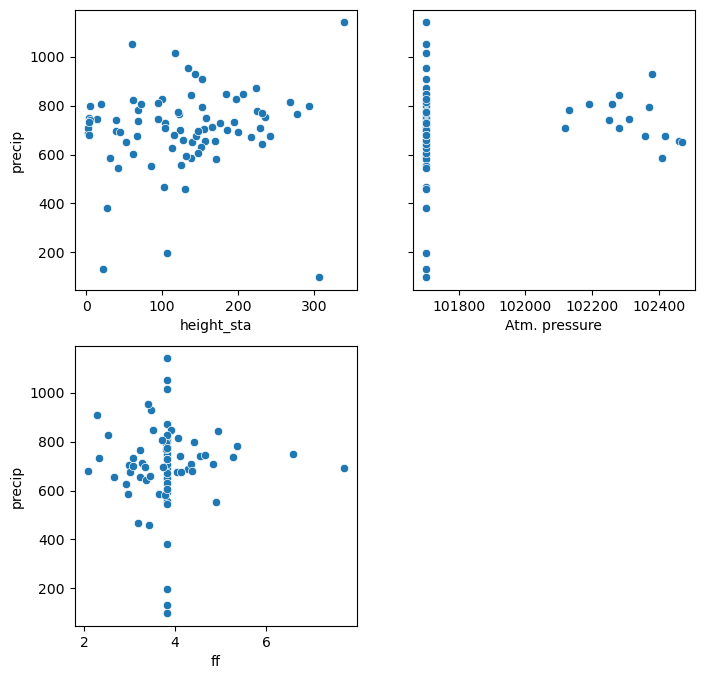

In [19]:
fig, axs = plt.subplots(2,2, sharey = True, figsize = [8,8])
for ax,i in zip(axs.flatten(),features) :
    sns.scatterplot(df, x = i, y = 'precip', ax = ax)
plt.delaxes(axs[1,1])

In [20]:
def color_strong_corr(val):
    color = 'red' if (abs(val) > 0.1) & (abs(val) <1.0) else 'black'
    return 'color: %s' % color
df[['precip','height_sta','Atm. pressure','ff']].corr().\
    style.applymap(color_strong_corr)

,precip,height_sta,Atm. pressure,ff
precip,1.000000,0.132454,0.090589,0.017994
height_sta,0.132454,1.000000,-0.128935,-0.227999
Atm. pressure,0.090589,-0.128935,1.000000,0.076491
ff,0.017994,-0.227999,0.076491,1.000000


In [21]:
df = weather_data.set_index('date')
df['t'] = df['t'] - 273.5

In [22]:
fig = px.line(df['2016-01-01':'2018-12-30'][['t','hu']].resample('D').mean(),
             title = 'Temperature (°C) - Humidity ratio')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [23]:
fig = px.line(df['2016-01-01':'2018-12-30']['precip'].resample('7D').sum(),
             title = 'Overall weekly precipitation')
fig.update_xaxes(
    rangeslider_visible=True
)
fig.show()

In [24]:
jan_2018 = df['2018-01-03':'2018-01-03'].reset_index()
jan_2018['ff'] = jan_2018['ff'] * 3.6
jan_2017 = df['2017-01-03':'2017-01-03'].reset_index()
jan_2016 = df['2016-01-03':'2016-01-03'].reset_index()

<Axes: title={'center': 'Avg Rainfall per station 2018/01/03'}, xlabel='Hour of the day', ylabel='Precipitation in mm'>

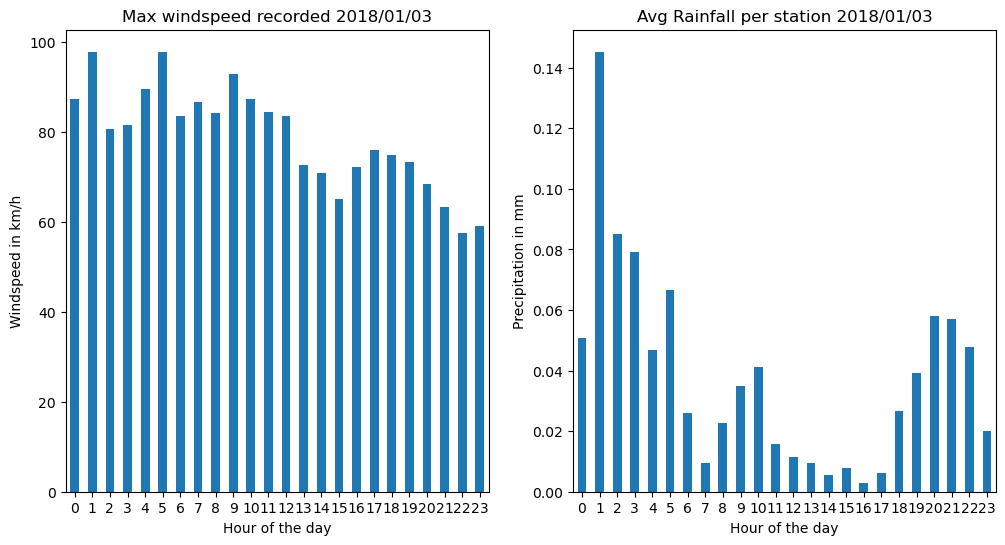

In [25]:
fig,axs = plt.subplots(1,2, figsize = (12,6))
jan_2018.groupby(jan_2018['date'].dt.hour)["ff"].max().plot(kind = 'bar', rot=0, title = "Max windspeed recorded 2018/01/03", xlabel = 'Hour of the day', ylabel = 'Windspeed in km/h', ax = axs[0])
jan_2018.groupby(jan_2018['date'].dt.hour)["precip"].mean().plot(kind = 'bar', rot=0, title = "Avg Rainfall per station 2018/01/03", xlabel = 'Hour of the day', ylabel = 'Precipitation in mm', ax = axs[1])

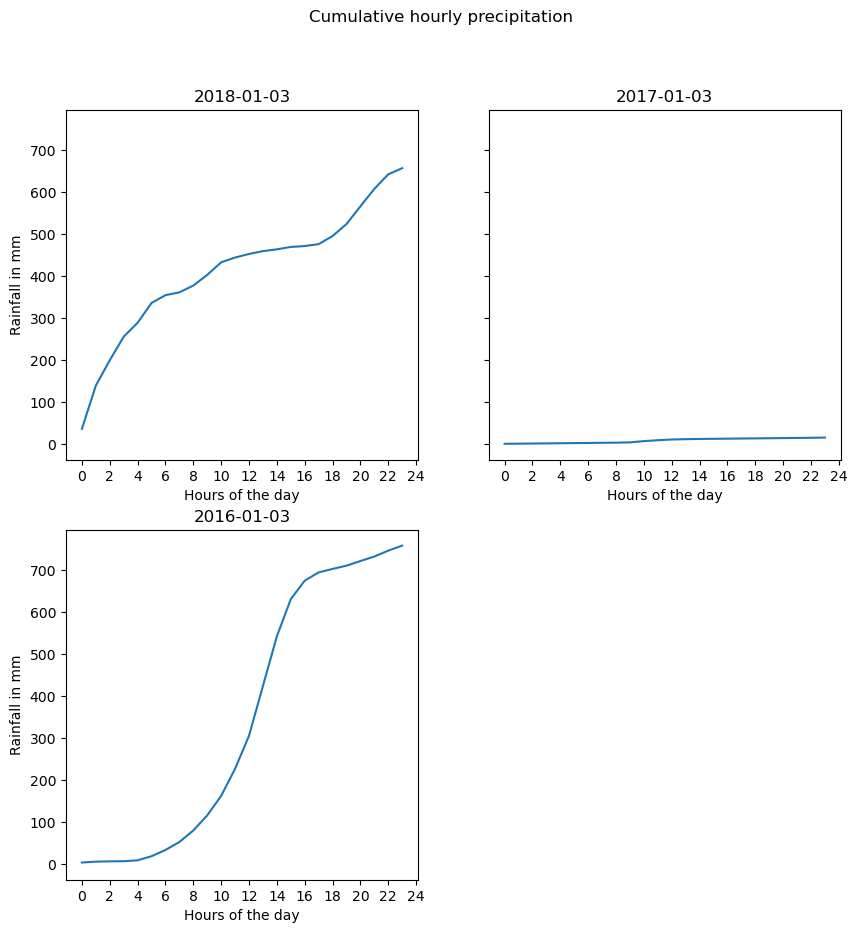

In [26]:
df = [jan_2018,jan_2017,jan_2016]
title = ["2018-01-03","2017-01-03","2016-01-03"]
fig, axs = plt.subplots(2,2, sharey = True, figsize = [10,10])
fig.suptitle("Cumulative hourly precipitation")
for ax,i,df,title in zip(axs.flatten(),features,df,title) :
    df.groupby(df['date'].dt.hour)["precip"].sum().cumsum().plot(kind = 'line',
                             title = title,
                             ylabel = 'Rainfall in mm',
                             xlabel = 'Hours of the day',
                             xticks = np.arange(0,26,2),
                             ax =  ax
                        )
plt.delaxes(axs[1,1])

In [27]:
gc.collect()


3114

In [28]:
#Daily forcast

In [29]:
date_range = pd.date_range(start= '2016-01-01', end = '2018-12-31',
                          freq='D').strftime("%Y-%m-%d")

In [30]:
init = time.time()


In [31]:
def daily_forecast(loc) :
    # We set the frequency of observations to 3 hours.
    # And we ignore intra-hour variations as we keep the value at the top of the hour
    
    df = weather_data.loc[weather_data['number_sta'] == loc]
    df = df.set_index('date')
    df['hours'] = [_.hour for _ in df.index]
    df['days'] = [_.dayofyear for _ in df.index]
    df['years'] = [_.year for _ in df.index]
    
   
    df['3'] = df['hours']%3
    df = df.loc[df['3'] == 0.0]
    df = pd.concat([
        df[_:_].drop_duplicates(subset = 'hours').reset_index(drop = True) for
        _ in date_range
                   ]
    )
    df = df[["height_sta","dd","ff","precip","hu","td","t","hours","days","years"]]
    
    return df


In [32]:
features = ["height_sta","dd","ff","precip","hu","td","t","days"]
days0 = np.arange(1,365,2)
days1 = np.arange(2,365,2)
len(days0) == len(days1)

True

In [33]:
def _3h_windowing(df:pd.DataFrame) :
    """ Generate inputs/targets couple then scale the data"""
    s_scaler = MinMaxScaler()
    
    days0 = np.arange(1,365,2)
    days1 = np.arange(2,365,2)
    X,y = [],[]
    
    for d0,d1 in zip(days0,days1) :
        x = df.loc[df['days'] == d0]
        z = df.loc[df['days'] == d1]
        
        if len(x) == len(z) :
            X.append(x)
            y.append(z)
            
    X = pd.concat(X)[features]
    y =  pd.concat(y)[features]
    
    X = pd.DataFrame(s_scaler.fit_transform(X))
    y = pd.DataFrame(s_scaler.fit_transform(y))
        
    return X,y, s_scaler

In [34]:
def split_dataset(X:pd.DataFrame, y:pd.DataFrame) :
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle = True, random_state=42)
    
    X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, shuffle = True, random_state=7)
    
    return {
        'train_set': tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(2),
        'val_set' : tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(2),
        'test_set' : [X_test, y_test]
           }

In [35]:
def model_history(model:'o', train_metrics:str, val_metrics:str, loss:str):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(loss)
    plt.plot(model.epoch, np.array(model.history[train_metrics]),
           label='Train')
    plt.plot(model.epoch, np.array(model.history[val_metrics]),
           label = 'Val')
    plt.legend()

In [36]:
df = daily_forecast(loc)


In [37]:
df.head(5)


,height_sta,dd,ff,precip,hu,td,t,hours,days,years
0,232.0,220.0,2.3,0.0,93.0,277.549988,278.549988,0,1,2016
1,232.0,210.0,2.1,0.0,96.0,277.049988,277.649994,3,1,2016
2,232.0,190.0,2.0,0.0,98.0,276.750000,277.049988,6,1,2016
3,232.0,180.0,2.4,0.0,98.0,275.149994,275.450012,9,1,2016
4,232.0,140.0,7.0,0.0,97.0,278.149994,278.549988,12,1,2016


In [38]:
X,y, s_scaler = _3h_windowing(df)


In [39]:
(X.shape,y.shape)


((3552, 8), (3552, 8))

In [40]:
train_set,val_set,test_set = split_dataset(X, y).values()

In [41]:
mlp_model = keras.Sequential([
    keras.Input(shape=(None, None,8)),
    layers.Dense(64, activation="relu",),
    layers.Dense(8)
])

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [43]:
def compile_fit(model:'o',
                train_set:'tf.dataset',
                val_set:'tf.dataset'
               ) :
     
    summary = model.summary()
    
    model.compile(
        optimizer = optimizer,
        loss = 'mse',
        metrics =[tf.keras.metrics.MeanAbsoluteError()]
    )
    
    history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks = [callback])
    
    return summary,history

In [44]:
mlp_history = compile_fit(mlp_model,
                          train_set,
                          val_set
                         )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, None, 64)    576       
                                                                 
 dense_1 (Dense)             (None, None, None, 8)     520       
                                                                 
Total params: 1096 (4.28 KB)
Trainable params: 1096 (4.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
40/40 [==============================] - 0s 1ms/step - loss: 0.3589 - mean_absolute_error: 0.4692 - val_loss: 0.3403 - val_mean_absolute_error: 0.4564
Epoch 2/100
40/40 [==============================] - 0s 530us/step - loss: 0.3023 - mean_absolute_error: 0.4280 - val_loss: 0.2860 - val_mean_absolute_error: 0.4162
Epoch 3/100
40/40 [==============================] - 0s 459us/step - loss: 0.2527 - mean_abs

40/40 [==============================] - 0s 433us/step - loss: 0.0169 - mean_absolute_error: 0.0821 - val_loss: 0.0171 - val_mean_absolute_error: 0.0833
Epoch 47/100
40/40 [==============================] - 0s 437us/step - loss: 0.0167 - mean_absolute_error: 0.0815 - val_loss: 0.0169 - val_mean_absolute_error: 0.0827
Epoch 48/100
40/40 [==============================] - 0s 447us/step - loss: 0.0166 - mean_absolute_error: 0.0810 - val_loss: 0.0168 - val_mean_absolute_error: 0.0822
Epoch 49/100
40/40 [==============================] - 0s 486us/step - loss: 0.0165 - mean_absolute_error: 0.0806 - val_loss: 0.0167 - val_mean_absolute_error: 0.0816
Epoch 50/100
40/40 [==============================] - 0s 427us/step - loss: 0.0164 - mean_absolute_error: 0.0801 - val_loss: 0.0166 - val_mean_absolute_error: 0.0811
Epoch 51/100
40/40 [==============================] - 0s 436us/step - loss: 0.0164 - mean_absolute_error: 0.0797 - val_loss: 0.0165 - val_mean_absolute_error: 0.0806
Epoch 52/100
40/4

40/40 [==============================] - 0s 415us/step - loss: 0.0150 - mean_absolute_error: 0.0708 - val_loss: 0.0149 - val_mean_absolute_error: 0.0706
Epoch 96/100
40/40 [==============================] - 0s 410us/step - loss: 0.0150 - mean_absolute_error: 0.0708 - val_loss: 0.0149 - val_mean_absolute_error: 0.0706
Epoch 97/100
40/40 [==============================] - 0s 431us/step - loss: 0.0150 - mean_absolute_error: 0.0707 - val_loss: 0.0149 - val_mean_absolute_error: 0.0705
Epoch 98/100
40/40 [==============================] - 0s 412us/step - loss: 0.0150 - mean_absolute_error: 0.0707 - val_loss: 0.0149 - val_mean_absolute_error: 0.0704
Epoch 99/100
40/40 [==============================] - 0s 434us/step - loss: 0.0150 - mean_absolute_error: 0.0706 - val_loss: 0.0149 - val_mean_absolute_error: 0.0704
Epoch 100/100
40/40 [==============================] - 0s 466us/step - loss: 0.0150 - mean_absolute_error: 0.0706 - val_loss: 0.0149 - val_mean_absolute_error: 0.0703


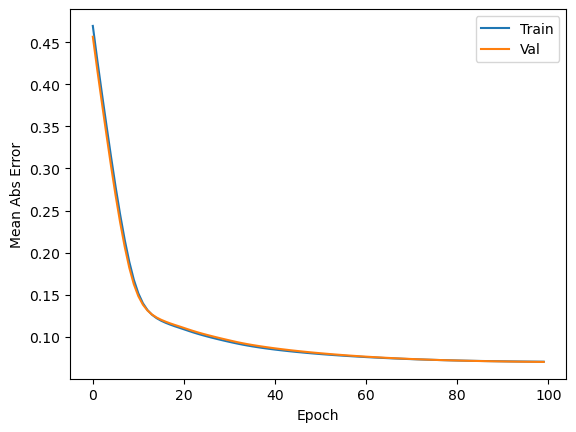

In [45]:
model_history(mlp_history[1],
             train_metrics = 'mean_absolute_error',
             val_metrics = 'val_mean_absolute_error',
             loss = 'Mean Abs Error')

In [46]:
y_true = test_set[1]
y_pred =  mlp_model.predict(test_set[0])

23/23 [==============================] - 0s 322us/step


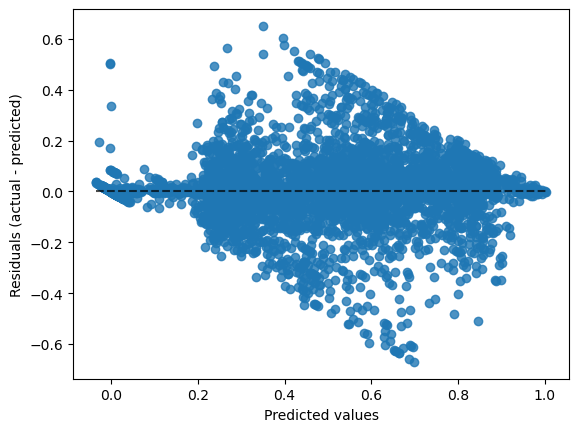

In [47]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_true, y_pred=y_pred)
display.plot()

In [48]:
test_scores = mlp_model.evaluate(test_set[0],test_set[1],verbose=2)

23/23 - 0s - loss: 0.0151 - mean_absolute_error: 0.0720 - 14ms/epoch - 616us/step


In [49]:
final = time.time()
print(f"DailyForecastModel done in {(final-init)/60} min")


DailyForecastModel done in 0.06597894827524821 min


In [50]:
gc.collect()


4006

In [51]:

init = time.time()


In [52]:
def _10days_forecast(loc:int, scaler = False) :
        
    df = weather_data.loc[weather_data['number_sta'] == loc]
    df = df.set_index('date')
    res = df[['ff','hu']].resample('D').mean()
    res['days'] = [_.dayofyear for _ in res.index]
    res['precip'] = df['precip'].resample('D').sum()
        
    df = df['t'].resample('12H').mean().values
    l = len(df)
    day_temp = np.arange(0,l,2)
    night_temp = np.arange(1,l,2)
    res['day_temp'] = [df[i] for i in day_temp]
    res['night_temp'] = [df[i] for i in night_temp]
    
    values = {_:np.mean(res[_]) for _ in res.columns}
    res = res.fillna(value = values)
    
    if scaler :
        res = pd.DataFrame(scaler.fit_transform(res),
                       index = res.index,
                       columns = res.columns)
    
    return res

In [53]:
df = _10days_forecast(loc,scaler = MinMaxScaler())


In [54]:
df.head()


,ff,hu,days,precip,day_temp,night_temp
date,,,,,,
2016-01-01,0.444375,0.872969,0.000000,0.025210,0.343072,0.309298
2016-01-02,0.615079,0.829663,0.002740,0.130252,0.425596,0.339497
2016-01-03,0.479751,0.848140,0.005479,0.273109,0.364180,0.311503
2016-01-04,0.414457,0.733894,0.008219,0.008403,0.369592,0.332639
2016-01-05,0.423600,0.781490,0.010959,0.016807,0.370646,0.331499


In [55]:
df_train = df['2016-01-01':'2017-12-30']
df_val = df['2018-01-01':'2018-03-30']
df_test = df['2018-01-01':'2018-12-30']

In [56]:
def window_dataset(data, n_steps, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + 10
    
    #expand dimensions to 3D to fit with LSTM inputs
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=10, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-10], x[-10:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-10], x[-10:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

In [57]:
train_set = window_dataset(df_train,
                           n_steps = 30,
                           batch_size = 1,
                           shuffle_buffer = 32,
                           multi_var = False)

In [58]:
val_set = window_dataset(df_val,
                           n_steps = 30,
                           batch_size = 1,
                           shuffle_buffer = 32,
                           multi_var = False)

In [59]:
TenDaysForecastModel = tf.keras.Sequential([
    layers.LSTM(128,
                activation='relu',
                kernel_initializer="glorot_uniform",
                bias_initializer="zeros",
                return_sequences=True,
                input_shape=(30, 6)
               ),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(6)
])

In [60]:
TenDaysForecastModel.compile(optimizer = 'Adam',
                             loss = 'mse',
                             metrics = 'mae'
                            )

In [61]:
TenDaysHistory = TenDaysForecastModel.fit(train_set,epochs = 100,
                         validation_data = val_set
                        )


Epoch 1/100
70/70 [==============================] - 1s 7ms/step - loss: 0.0681 - mae: 0.2042 - val_loss: 0.0269 - val_mae: 0.1243
Epoch 2/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0388 - mae: 0.1512 - val_loss: 0.0451 - val_mae: 0.1649
Epoch 3/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0297 - mae: 0.1304 - val_loss: 0.0316 - val_mae: 0.1338
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0314 - mae: 0.1344 - val_loss: 0.0277 - val_mae: 0.1227
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0251 - mae: 0.1183 - val_loss: 0.0230 - val_mae: 0.1099
Epoch 6/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0253 - mae: 0.1178 - val_loss: 0.0276 - val_mae: 0.1217
Epoch 7/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0270 - mae: 0.1263 - val_loss: 0.0315 - val_mae: 0.1315
Epoch 8/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0270 - m

70/70 [==============================] - 0s 6ms/step - loss: 0.0129 - mae: 0.0826 - val_loss: 0.0237 - val_mae: 0.1079
Epoch 64/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0145 - mae: 0.0881 - val_loss: 0.0241 - val_mae: 0.1132
Epoch 65/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0137 - mae: 0.0837 - val_loss: 0.0257 - val_mae: 0.1126
Epoch 66/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0136 - mae: 0.0849 - val_loss: 0.0223 - val_mae: 0.1055
Epoch 67/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0136 - mae: 0.0857 - val_loss: 0.0246 - val_mae: 0.1107
Epoch 68/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0139 - mae: 0.0850 - val_loss: 0.0238 - val_mae: 0.1088
Epoch 69/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0128 - mae: 0.0811 - val_loss: 0.0238 - val_mae: 0.1091
Epoch 70/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0131 - mae: 0

In [62]:
test_set =  window_dataset(df_test,
                           n_steps = 30,
                           batch_size = 1,
                           shuffle_buffer = 32,
                           multi_var = False)

In [63]:
test_mae = TenDaysForecastModel.evaluate(test_set)


33/33 [==============================] - 0s 2ms/step - loss: 0.0215 - mae: 0.1036


In [64]:
df = pd.Series([np.mean(TenDaysHistory.history['mae']),
         np.mean(TenDaysHistory.history['val_mae']),
         test_mae[1]
        ])
df.index = ['train set','val set','test set']

<Axes: ylabel='MAE'>

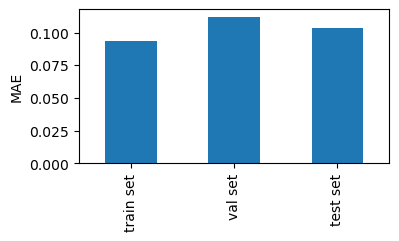

In [65]:
df.plot(kind = 'bar',ylabel = 'MAE', figsize = [4,2])


In [66]:
final = time.time()


In [67]:
print(f"TenDaysForecastModel done in {(final-init)/60} min")

TenDaysForecastModel done in 0.7250260472297668 min


In [68]:
gc.collect()


1071